In [213]:
from scipy.signal import csd, welch, chirp
import scipy.io.wavfile as wav
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import os

In [214]:
FILENAME = "output.wav"
F_S = 44100

In [215]:
CHIRP_DURATION = 3.0
CHIRP_LOW = 500
CHIRP_HIGH = 4000
CHIRP_LENGTH = int(CHIRP_DURATION * F_S)
t = np.linspace(0, CHIRP_DURATION, int(CHIRP_DURATION * F_S), endpoint=False)
x = scipy.signal.chirp(t, f0=CHIRP_LOW, f1=CHIRP_HIGH, t1=CHIRP_DURATION, method='linear')

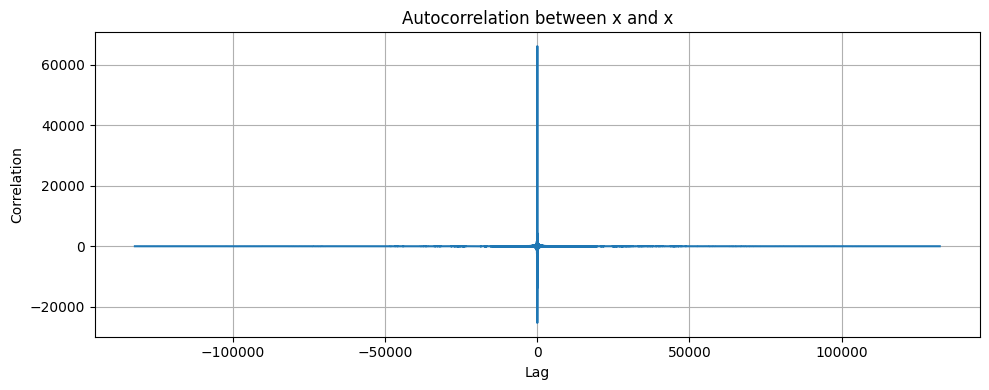

In [216]:
nperseg = 2048  # for spectral estimation
R_xx = np.correlate(x, x, mode='full')
lags = np.arange(-len(x) + 1, len(x))  # Use len(x) instead of len(y)

plt.figure(figsize=(10, 4))
plt.plot(lags, R_xx)
plt.title("Autocorrelation between x and x")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
#plt.xlim(-500, 500)
plt.tight_layout()
plt.show()

In [217]:
_, y = scipy.io.wavfile.read(os.path.join(os.getcwd(), FILENAME))
y_scaled = y/np.max(np.abs(y))

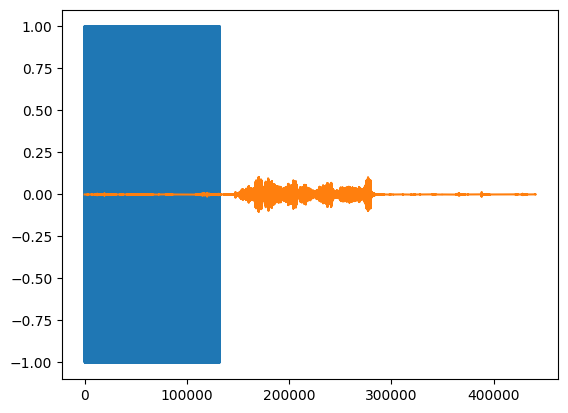

In [218]:
plt.plot(x)
plt.plot(y)

In [219]:
R_xy = np.correlate(x, y)
print(x.shape, y.shape, cross.shape)

(132300,) (441000,) (308701,)


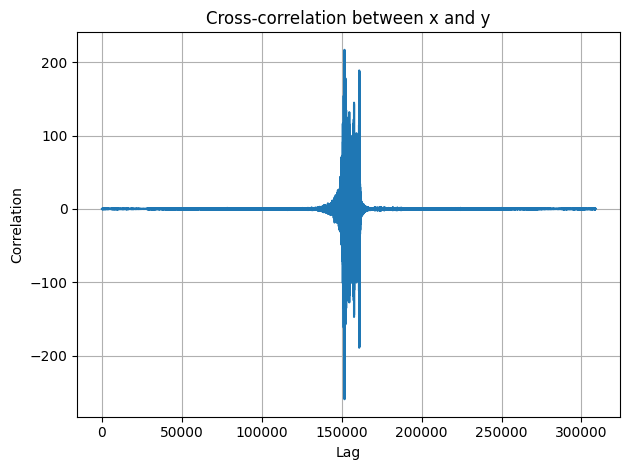

In [220]:
plt.plot(R_xy)
plt.title("Cross-correlation between x and y")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [221]:
peaks,props = scipy.signal.find_peaks(np.abs(R_xy), height=180, distance=200)

peak_heights = props["peak_heights"]
print(peaks, peak_heights)

[151776 160959] [259.19540843 189.05162877]


In [222]:
print(f"Value of correlation for chirp simulation: {peak_heights[0]} at index {peaks[0]}")

Value of correlation for chirp simulation: 259.19540843116096 at index 151776


In [223]:
shift = peaks[0]
x_shifted = np.pad(x, (shift, y.size - shift - CHIRP_LENGTH), "constant", constant_values=0)

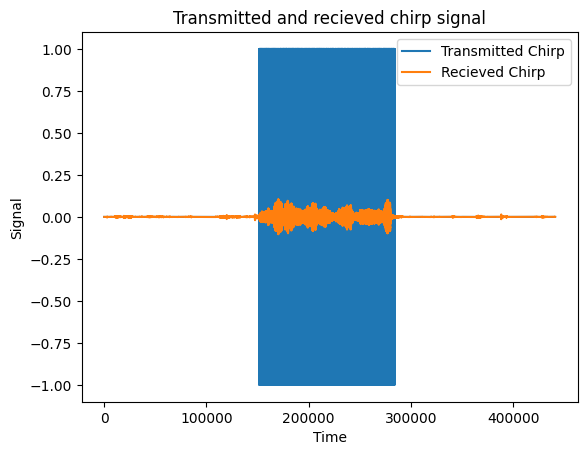

In [224]:
plt.plot(x_shifted)
plt.plot(y)
plt.title("Transmitted and recieved chirp signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend(["Transmitted Chirp","Recieved Chirp"])

In [225]:
nonzero_indices = np.flatnonzero(x_shifted)
first_nonzero_index = np.flatnonzero(x_shifted)[0]
print("First nonzero index in x_shifted:", first_nonzero_index)
last_nonzero_index = nonzero_indices[-1]
print("Last nonzero index in x_shifted:", last_nonzero_index)


First nonzero index in x_shifted: 151776
Last nonzero index in x_shifted: 284075


In [230]:
x_cropped = x_shifted[shift:shift+CHIRP_LENGTH]
y_cropped = y[shift:shift+CHIRP_LENGTH]
x_cropped_1 = x_shifted[shift+10000:shift+CHIRP_LENGTH]
y_cropped_1 = y[shift+10000:shift+CHIRP_LENGTH]
x_cropped_2 = x_shifted[shift:shift+CHIRP_LENGTH-10000]
y_cropped_2 = y[shift:shift+CHIRP_LENGTH-10000]

In [231]:
noise_before = y[:first_nonzero_index]
noise_after = y[last_nonzero_index+10000:]
noise_region = np.concatenate([noise_before, noise_after])
noise_power = np.mean(noise_region**2)

snr_db = 10 * np.log10(np.mean((x_cropped)**2) / noise_power)
print("SNR (dB):", snr_db)

SNR (dB): 56.94158257801873


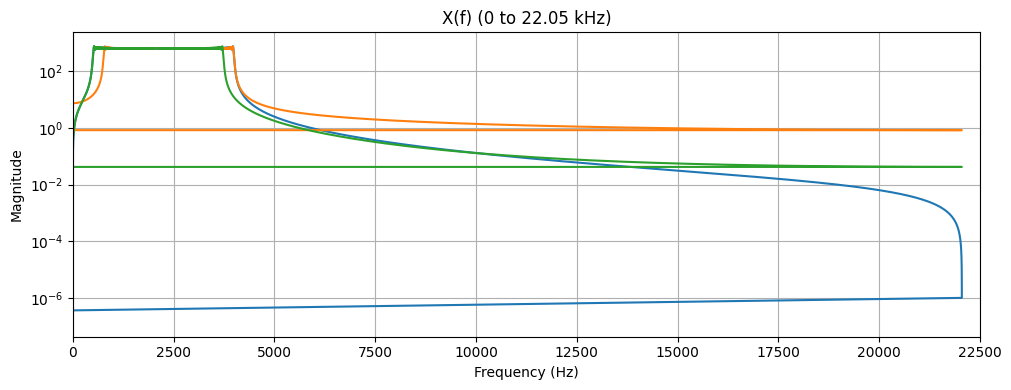

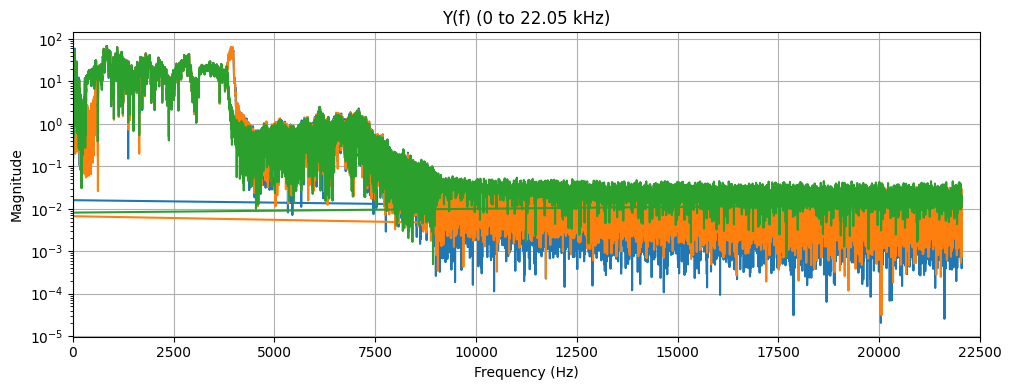

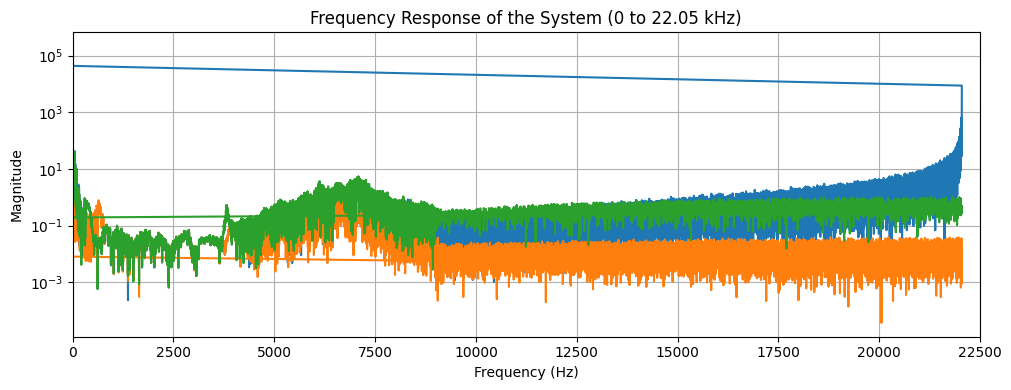

In [232]:
X_freq = np.fft.fft(x_cropped)
Y_freq = np.fft.fft(y_cropped)
freqs = np.fft.fftfreq(len(x_cropped), d=1/F_S)
H_est = Y_freq/X_freq

X_freq_1 = np.fft.fft(x_cropped_1)
Y_freq_1 = np.fft.fft(y_cropped_1)
freqs_1 = np.fft.fftfreq(len(x_cropped_1), d=1/F_S)
H_est_1 = Y_freq_1/X_freq_1

X_freq_2 = np.fft.fft(x_cropped_2)
Y_freq_2 = np.fft.fft(y_cropped_2)
freqs_2 = np.fft.fftfreq(len(x_cropped_2), d=1/F_S)
H_est_2 = Y_freq_2/X_freq_2


# Plot X(f)
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(X_freq))
plt.semilogy(freqs_1, np.abs(X_freq_1))
plt.semilogy(freqs_2, np.abs(X_freq_2))
plt.title("X(f) (0 to 22.05 kHz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.xlim(0,22500)
plt.show()

# Plot Y(f)
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_freq))
plt.semilogy(freqs_1, np.abs(Y_freq_1))
plt.semilogy(freqs_2, np.abs(Y_freq_2))
plt.title("Y(f) (0 to 22.05 kHz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.xlim(0,22500)
plt.show()

# Plot the frequency response
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(H_est))
plt.semilogy(freqs_1, np.abs(H_est_1))
plt.semilogy(freqs_2, np.abs(H_est_2))
plt.title("Frequency Response of the System (0 to 22.05 kHz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.xlim(0,22500)
plt.show()

In [233]:
# Create a mask for the desired frequency range
mask = (np.abs(freqs) >= 500) & (np.abs(freqs) <= 4000)
H_est_cropped = H_est.copy()
H_est_cropped[~mask] = 0

mask_1 = (np.abs(freqs_1) >= 500) & (np.abs(freqs_1) <= 4000)
H_est_cropped_1 = H_est_1.copy()
H_est_cropped_1[~mask_1] = 0

mask_2 = (np.abs(freqs_2) >= 500) & (np.abs(freqs_2) <= 4000)
H_est_cropped_2 = H_est_2.copy()
H_est_cropped_2[~mask_2] = 0

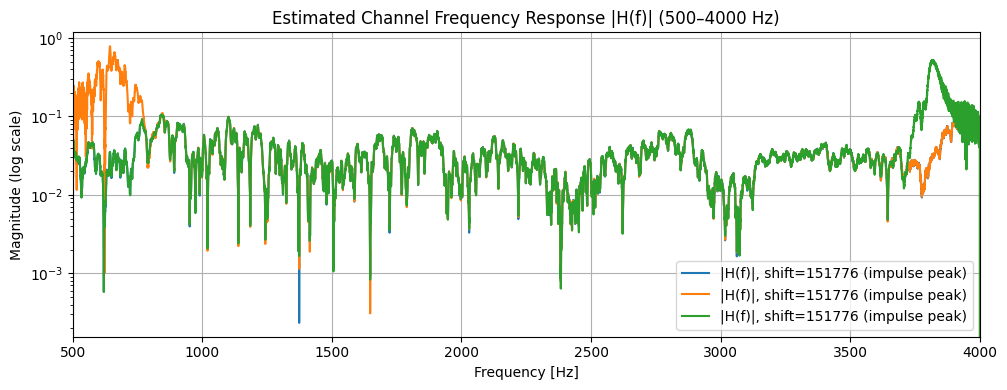

In [234]:
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(H_est_cropped), label="|H(f)|, shift=151776 (impulse peak)")
plt.semilogy(freqs_1, np.abs(H_est_cropped_1), label="|H(f)|, shift=151776 (impulse peak)")
plt.semilogy(freqs_2, np.abs(H_est_cropped_2), label="|H(f)|, shift=151776 (impulse peak)")
#plt.axvline(x=650, ymin=0, ymax=0.7, color='red', linestyle='--')  # Below 10^-2
#plt.axvline(x=650, ymin=0.82, ymax=1, color='red', linestyle='--',label = '650Hz')  # Above 7 * 10^-2
plt.title("Estimated Channel Frequency Response |H(f)| (500–4000 Hz)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(500,4000)
plt.show()


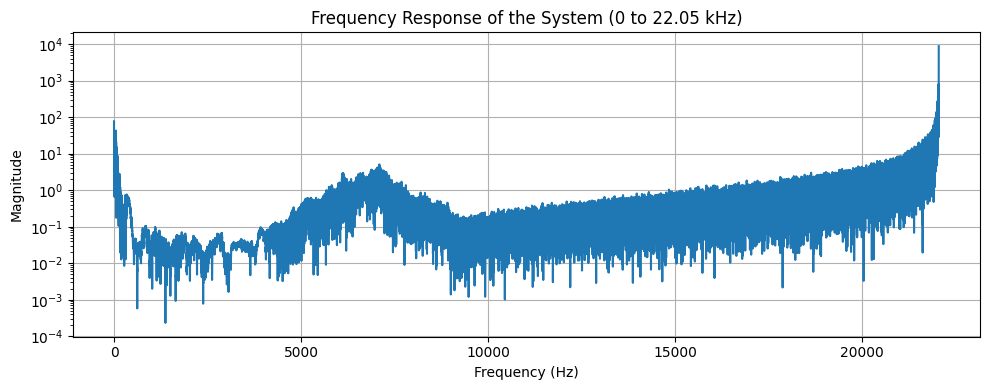

In [235]:
# Compute the FFT frequencies
freqs = np.fft.fftfreq(len(x_cropped), d=1/F_S)

# Only keep the positive frequencies (0 to Nyquist)
positive_freqs = freqs[:len(freqs)//2]
H_est_positive = np.abs(H_est[:len(freqs)//2])

# Plot the frequency response
plt.figure(figsize=(10, 4))
plt.semilogy(positive_freqs, H_est_positive)
plt.title("Frequency Response of the System (0 to 22.05 kHz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

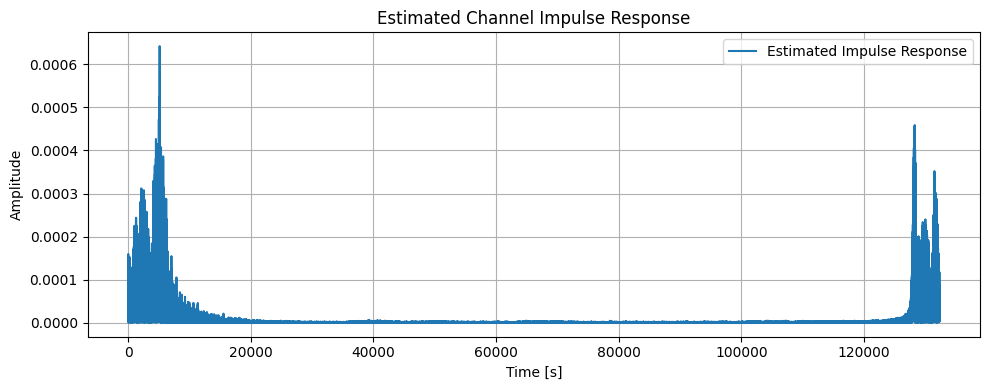

In [241]:
# Optional: Crop frequency domain (e.g., to a desired band)
# H_est = H_est[freq_mask]  # Define `freq_mask` as needed
# freqs = freqs[freq_mask]

# Inverse FFT to get impulse response
h_est = np.fft.ifft(H_est_cropped)

# Optional: Crop impulse response (e.g., to a window of expected delay spread)
# h_est = h_est[:desired_length]

# Optional: Take real part if you expect a real-valued impulse response
h_est = np.abs(h_est)

# Plot the impulse response
plt.figure(figsize=(10, 4))
plt.plot(h_est, label='Estimated Impulse Response')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Estimated Channel Impulse Response')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
